In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ttest_rel
from tqdm import tqdm


## 1d Gaussian Score Matching

In [2]:
class Gaussian_1d(nn.Module):
    def __init__(self):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.randn(1, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.abs(torch.randn(1, dtype=torch.float64)))

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2/self.sigma**2)

In [3]:
def compute_psi_1d(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

In [4]:
def J_1d(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0

    for t in range(T):
        x = x_t[t]
        psi_x = compute_psi_1d(x, model)
        psi_x_real = - (x - model.mu)/model.sigma**2

        divergence = torch.autograd.grad(psi_x.sum(), x, create_graph=True)[0].sum()
        divergence_real = -1/model.sigma**2
        norm_squared = (psi_x ** 2).sum()
        norm_squared_real = (psi_x_real ** 2).sum()

        real_sum += 0.5 * norm_squared_real + divergence_real
        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T, real_sum / T

In [5]:
def optimize_theta_gaussian_1d(
    x_t_all, num_epochs=1000, learning_rate=1e-3,
    display_loss=True,
):
    model = Gaussian_1d()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses, real_losses = [], []
    estimated_mus = []
    estimated_stds = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = x_t_all.clone().detach().to(dtype=torch.float32)
        loss, real_loss = J_1d(x_t_tensor, model)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        real_losses.append(real_loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_stds.append(model.sigma.detach().numpy().copy())

        if display_loss:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_stds

In [6]:
mean, std = 0, 1
x = torch.normal(mean=mean, std=std, size=(1000,))

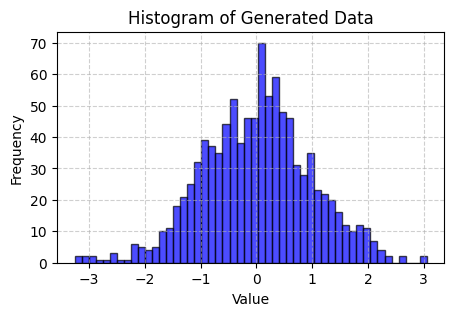

In [7]:
plt.figure(figsize=(5, 3))
plt.hist(x.numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
epochs = 50
model, losses, real_losses, estimated_mu, estimated_std = optimize_theta_gaussian_1d(
    x, num_epochs=epochs, learning_rate=1e-2)

Epoch 0/50, Loss: 10685.767578125
Epoch 1/50, Loss: 7375.88037109375
Epoch 2/50, Loss: 4912.52099609375
Epoch 3/50, Loss: 3156.41455078125
Epoch 4/50, Loss: 1956.7535400390625
Epoch 5/50, Loss: 1170.7398681640625
Epoch 6/50, Loss: 676.2064208984375
Epoch 7/50, Loss: 377.0192565917969
Epoch 8/50, Loss: 202.74453735351562
Epoch 9/50, Loss: 104.9144287109375
Epoch 10/50, Loss: 51.981510162353516
Epoch 11/50, Loss: 24.40801429748535
Epoch 12/50, Loss: 10.628066062927246
Epoch 13/50, Loss: 4.0722270011901855
Epoch 14/50, Loss: 1.1515530347824097
Epoch 15/50, Loss: -0.021769041195511818
Epoch 16/50, Loss: -0.40285760164260864
Epoch 17/50, Loss: -0.45456430315971375
Epoch 18/50, Loss: -0.4754204750061035
Epoch 19/50, Loss: -0.49150216579437256
Epoch 20/50, Loss: -0.49712929129600525
Epoch 21/50, Loss: -0.5183924436569214
Epoch 22/50, Loss: -0.5152369141578674
Epoch 23/50, Loss: -0.5152369141578674
Epoch 24/50, Loss: -0.5215902924537659
Epoch 25/50, Loss: -0.5163215398788452
Epoch 26/50, Loss:

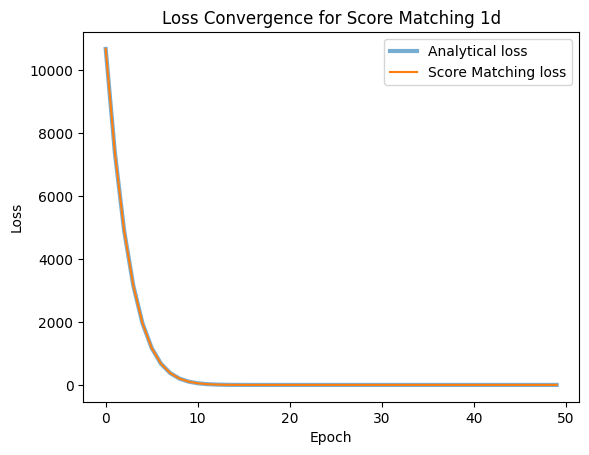

In [12]:
plt.plot(real_losses, linewidth=3, alpha=0.6, label="Analytical loss")
plt.plot(losses, label="Score Matching loss", linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching 1d')
plt.legend()
plt.show()

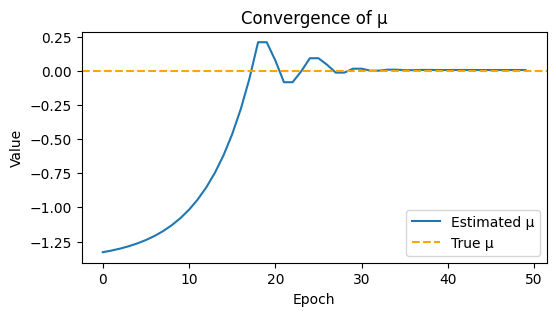

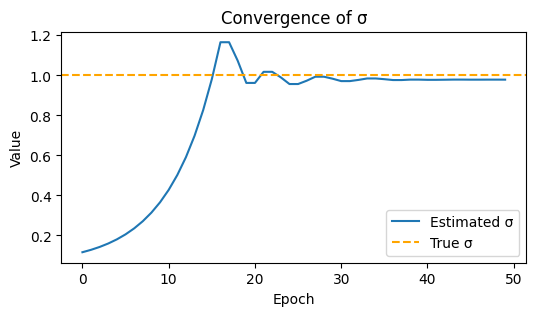

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(estimated_mu, label="Estimated μ")
plt.axhline(mean, color='orange', linestyle='--', label="True μ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(estimated_std, label="Estimated σ")
plt.axhline(std, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [ ]:
print("Final estimated μ:", estimated_mu[-1][0])
print("True μ:", mean)
print("\nFinal estimated σ:\n", estimated_std[-1][0])
print("True σ:\n", std)

Final estimated μ: 0.0056332769506071715
True μ: 0

Final estimated σ:
 0.9787437415365288
True σ:
 1


### Statistical Testing

In [ ]:
num_trials = 5
epochs = 50
learning_rate = 1e-2

true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [17]:
json_file = 'data/trial_results.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

for trial in tqdm(range(num_trials), desc="Running trials"):
    mean = np.random.uniform(1, 5)
    std = np.random.uniform(1, 3)
    
    x = torch.normal(mean=mean, std=std, size=(1000,))
    
    _, _, _, estimated_mu, estimated_std = optimize_theta_gaussian_1d(
        x, num_epochs=epochs, learning_rate=learning_rate, display_loss=False)
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr": learning_rate,
        "true_mean": mean,
        "true_std": std,
        "estimated_mean": estimated_mu[-1][0].item(),
        "estimated_std": estimated_std[-1][0].item()
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials:   0%|          | 0/5 [00:00<?, ?it/s]

Running trials: 100%|██████████| 5/5 [08:12<00:00, 98.54s/it] 


In [ ]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mean'] for trial in trial_results])
true_cov = np.array([trial['true_std'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mean'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_std'] for trial in trial_results])

In [ ]:
mean_ttest = ttest_rel(true_mu, estimated_mu)
std_ttest = ttest_rel(true_cov, estimated_cov)

print(f"Mean difference (paired t-test): p-value = {mean_ttest.pvalue}")
print(f"Variance difference (paired t-test): p-value = {std_ttest.pvalue}")

alpha = 0.05
if mean_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated means.")
else:
    print("No statistically significant difference in estimated means.")

if std_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated variances.")
else:
    print("No statistically significant difference in estimated variances.")

Mean difference (paired t-test): p-value = 0.2401774175176807
Variance difference (paired t-test): p-value = 0.30769906430455984
No statistically significant difference in estimated means.
No statistically significant difference in estimated variances.


## Multivariate Gaussian Score Matching

### Gaussian Model

In [20]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        torch.manual_seed(123)
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.M = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        A = torch.randn(dimensions, dimensions, dtype=torch.float64)
        self.M = nn.Parameter(torch.mm(A, A.T))    
        self.M.data += dimensions * torch.eye(dimensions, dtype=torch.float64)
        
    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff.T @ self.M @ diff)

### Psi calculation (Score Matching & Analytical)

In [21]:
def compute_psi(x, model):
    nn_output = model(x)
    psi = torch.autograd.grad(
        nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
    return psi

In [22]:
def gaussian_psi(x, mu=torch.tensor([0.0, 0.0]), M=torch.eye(2, dtype=torch.float64)):
    return -M @ (x - mu)

### Divergence calculation (Jacobian)

In [23]:
def compute_divergence_jacobian(x, model):
    jacobian = torch.autograd.functional.jacobian(lambda x: compute_psi(x, model), x, create_graph=True)
    divergence = jacobian.diagonal(dim1=-2, dim2=-1).sum(-1)  # Sum diagonal elements
    return divergence

### Objective Funciton J Calculation (Score Matching & Analytical) 

In [24]:
def gaussian_J(x_t, mu=torch.tensor([0.0, 0.0]), M=torch.eye(2, dtype=torch.float32)):
    diff = x_t - mu
    trace_term = -torch.trace(M)
    quadratic_term = diff.T @ M @ M @ diff
    return trace_term, quadratic_term

In [25]:
def J(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0

    for t in range(T):
        x = x_t[t]
        x.requires_grad_()
        psi_x_t = compute_psi(x, model)
        
        psi_x_t_real = gaussian_psi(x, model.mu.detach(), model.M.detach())
        if not torch.allclose(psi_x_t, psi_x_t_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x_t} \
                is different from the analytical solution {psi_x_t_real}"
                )
        
        divergence = 0
        for i in range(x.shape[-1]):
            gradient = torch.autograd.grad(psi_x_t[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]
        norm_squared = (psi_x_t ** 2).sum()
        
        divergence_real, norm_squared_real = gaussian_J(x, model.mu.detach(), model.M.detach())

        if not torch.allclose(divergence, divergence_real, atol=1e-4):
            raise ValueError(
                f"Calculated divergence value {divergence} \
                is different from the analytical solution {divergence_real}"
                )
        if not torch.allclose(norm_squared, norm_squared_real, atol=1e-4):
            raise ValueError(
                f"Calculated norm squared value {norm_squared} \
                is different from the analytical solution {norm_squared_real}"
                )
        
        real_sum += 0.5 * norm_squared_real + divergence_real
        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T, real_sum / T

### Optimization Loop (Normal & Batch)

In [59]:
def optimize_theta_gaussian(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_M=1e-4, display_loss=True,
    ):
    model = Gaussian(dim)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.M], "lr": learning_rate_M},
        ]
    )
    losses = []
    real_losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)
        loss, real_loss = J(x_t_tensor, model)

        loss.backward()

        real_mu_grad = model.M@model.M@model.mu - model.M@model.M@(torch.mean(x_t_tensor, dim = 0))
        diff = x_t_tensor - model.mu.T
        covmat = ((1/(2*len(x_t_tensor))) * diff.T @ diff)
        real_M_grad = -torch.eye(2) + model.M @ covmat + covmat @ model.M

        if not torch.allclose(model.mu.grad, real_mu_grad, atol=1e-4):
            raise ValueError(
                f"Calculated mu grad value {model.mu.grad} \
                is different from the analytical solution {real_mu_grad}"
                )
        if not torch.allclose(model.M.grad, real_M_grad, atol=1e-4):
            raise ValueError(
                f"Calculated M grad value {model.M.grad} \
                is different from the analytical solution {real_M_grad}"
                )
        
        optimizer.step()

        losses.append(loss.item())
        real_losses.append(real_loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.M.detach().numpy().copy())

        if display_loss:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_covs

### Data Generation

In [53]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    # np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [28]:
n = 1000
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
# mu = np.array([0.0, 0.0, 0.0])
# cov = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
x_t_all = generate_multivariate_gaussian_data(mu, cov, n)
dim = x_t_all.shape[1]

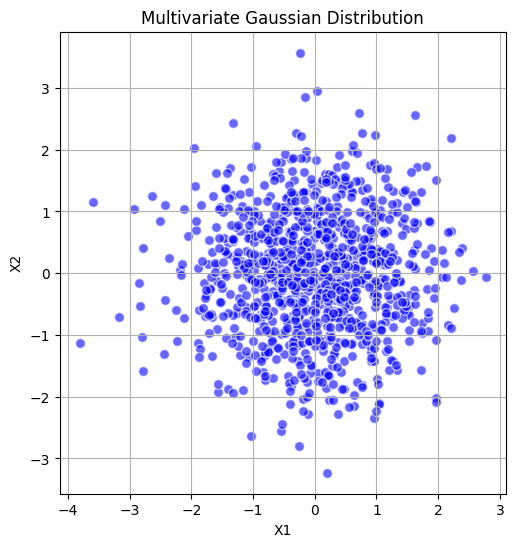

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Training Loop

In [ ]:
epochs = 50
model, losses, real_losses, estimated_mus, estimated_cov = optimize_theta_gaussian(
    x_t_all, dim, num_epochs=epochs, learning_rate_mu=1e-3, learning_rate_M=1e-3,
    )

C:\Users\79217\AppData\Local\Temp\ipykernel_22444\4037767569.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  return -0.5 * (diff.T @ self.M @ diff)


Epoch 0/50, Loss: 2.675836757792473
Epoch 1/50, Loss: 2.6699397802747624
Epoch 2/50, Loss: 2.6629010569569833
Epoch 3/50, Loss: 2.6545086242411853
Epoch 4/50, Loss: 2.644515204706732
Epoch 5/50, Loss: 2.6326341644253097
Epoch 6/50, Loss: 2.6185359222714957
Epoch 7/50, Loss: 2.601845407173163
Epoch 8/50, Loss: 2.582141465820632
Epoch 9/50, Loss: 2.558959548904523
Epoch 10/50, Loss: 2.5317995803879825
Epoch 11/50, Loss: 2.500141671777885
Epoch 12/50, Loss: 2.4634732986424153
Epoch 13/50, Loss: 2.421332689803134
Epoch 14/50, Loss: 2.3733743899918527
Epoch 15/50, Loss: 2.319463984078098
Epoch 16/50, Loss: 2.259809261220964
Epoch 17/50, Loss: 2.1951335845963387
Epoch 18/50, Loss: 2.119380838461469
Epoch 19/50, Loss: 2.030322741994287
Epoch 20/50, Loss: 1.9285394769295643
Epoch 21/50, Loss: 1.811791748553021
Epoch 22/50, Loss: 1.6754292072363348
Epoch 23/50, Loss: 1.5169974676202143
Epoch 24/50, Loss: 1.3349242282502605
Epoch 25/50, Loss: 1.1276776565270965
Epoch 26/50, Loss: 0.8949324055692

### Loss and Parameters Plots

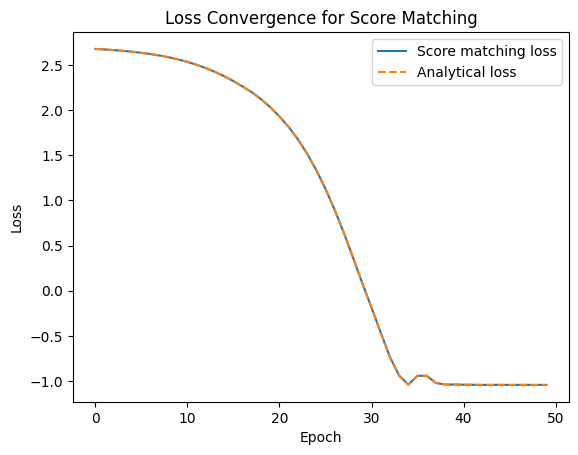

In [32]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, label="Analytical loss", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()

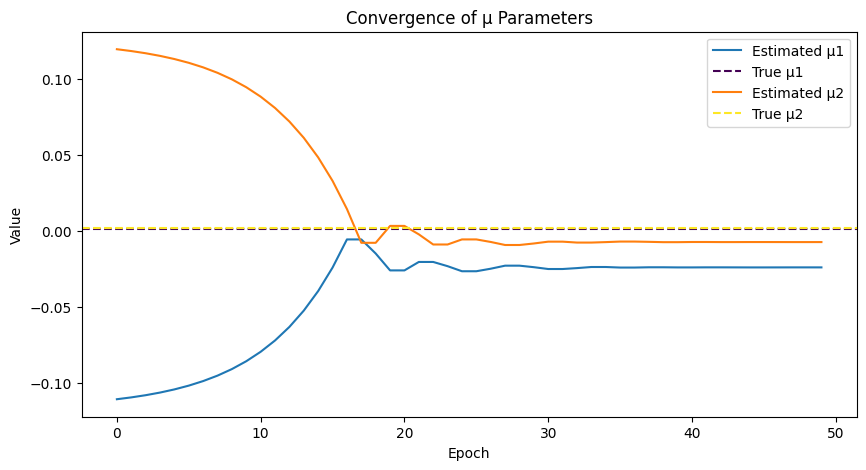

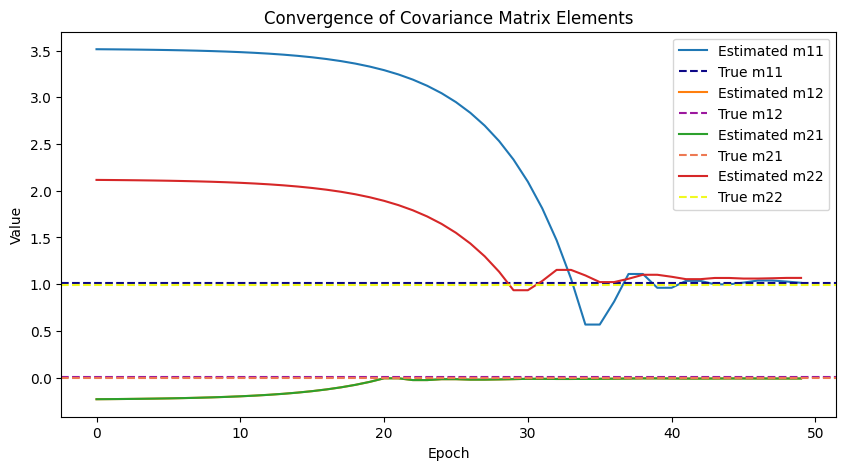

In [ ]:
estimated_mus = np.array(estimated_mus)  # (epochs, d)
d = estimated_mus.shape[1]
colors_mu = plt.cm.viridis(np.linspace(0, 1, d))

plt.figure(figsize=(10, 5))
for i in range(d):
    plt.plot(estimated_mus[:, i], label=f"Estimated μ{i+1}")
    plt.axhline(
        mu[i] + 0.001 * (i + 1), 
        linestyle='--', color=colors_mu[i], label=f"True μ{i+1}")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

estimated_covs_array = np.array(estimated_cov)  # (epochs, d, d)
epochs, d, _ = estimated_covs_array.shape


colors_cov = plt.cm.plasma(np.linspace(0, 1, d * d))
color_map = np.reshape(colors_cov, (d, d, 4))
jitter = 0.01
plt.figure(figsize=(10, 5))
for i in range(d):
    for j in range(d):
        plt.plot(estimated_covs_array[:, i, j], label=f"Estimated m{i+1}{j+1}")
        if i == j:  # Diagonal elements (e.g., m11, m22)
            plt.axhline(cov[i, j] + jitter * (1 if i % 2 == 0 else -1), linestyle='--', color=color_map[i, j], label=f"True m{i+1}{j+1}")
        elif i < j:  # Off-diagonal unique pairs (e.g., m12)
            plt.axhline(cov[i, j] + jitter, linestyle='--', color=color_map[i, j], label=f"True m{i+1}{j+1}")
        else:  # Symmetric off-diagonal elements (e.g., m21)
            plt.axhline(cov[i, j] - jitter, linestyle='--', color=color_map[i, j], label=f"True m{i+1}{j+1}")


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of Covariance Matrix Elements')
plt.show()

### Final Parameter estimations

In [ ]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", torch.linalg.inv(torch.tensor(estimated_covs[-1])))
print("True Σ:\n", cov)

Final estimated μ: [0.01836684 0.00171814]
True μ: [0. 0.]

Final estimated Σ:
 tensor([[1.0118, 0.0275],
        [0.0275, 0.9939]], dtype=torch.float64)
True Σ:
 [[1. 0.]
 [0. 1.]]


In [ ]:
model_mu = torch.tensor(estimated_mus[-1])
model_cov = torch.linalg.inv(torch.tensor(estimated_cov[-1]))
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

C:\Users\79217\AppData\Local\Temp\ipykernel_7676\2233108499.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.random.multivariate_normal(mean, cov, num_samples)


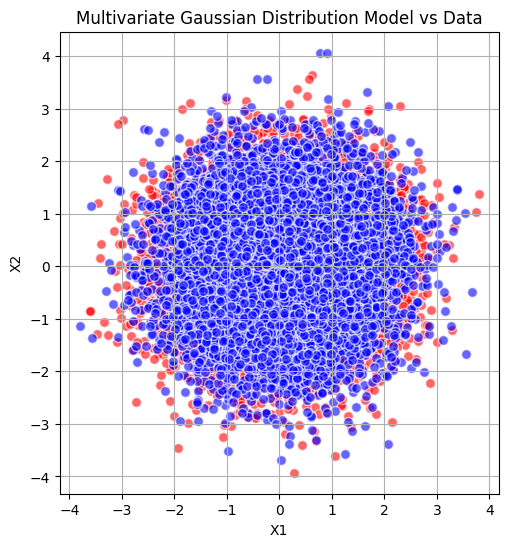

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Statistical Significance

In [76]:
num_trials = 10
epochs = 50
learning_rate_mu = 1e-3
learning_rate_M = 1e-3

true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [77]:
json_file = 'data/trial_results_2d.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

n = 1000
for trial in tqdm(range(num_trials), desc="Running trials"):
    mu = np.random.uniform(-1, 1, size=(2,))    
    random_matrix = np.random.rand(2, 2)
    cov = np.dot(random_matrix.T, random_matrix)
    
    x = generate_multivariate_gaussian_data(mu, cov, n)
    dim = x.shape[1]
    
    _, _, _, estimated_mu, estimated_cov = optimize_theta_gaussian(
        x, dim, num_epochs=epochs,
        learning_rate_mu=learning_rate_mu,
        learning_rate_M=learning_rate_M,
        display_loss=False)
    
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr_mu": learning_rate_mu,
        "lr_M": learning_rate_M,
        "true_mu": mu.tolist(),
        "true_cov": cov.tolist(),
        "estimated_mu": estimated_mu[-1].tolist(),
        "estimated_cov": torch.linalg.inv(torch.tensor(estimated_cov[-1])).tolist(),
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials: 100%|██████████| 10/10 [1:22:59<00:00, 497.95s/it]


In [78]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mu'] for trial in trial_results])
true_cov = np.array([trial['true_cov'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mu'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_cov'] for trial in trial_results])

In [ ]:
true_mu = np.array(true_mu)
true_cov = np.array(true_cov)
estimated_mu = np.array(estimated_mu)
estimated_cov = np.array(estimated_cov)

mean_ttest = ttest_rel(true_mu, estimated_mu)
std_ttest = ttest_rel(true_cov, estimated_cov)  # Compare variances


mean_pvalues = mean_ttest.pvalue
print(f"Mean difference (paired t-test): p-value = {mean_pvalues}")
variance_pvalues = std_ttest.pvalue
print(f"Variance difference (paired t-test): p-value = {variance_pvalues}")

alpha = 0.05
mean_significance = mean_pvalues < alpha
if np.any(mean_significance):
    print("The model produces statistically significant differences in estimated means.")
else:
    print("No statistically significant difference in estimated means.")

variance_significance = variance_pvalues < alpha
if np.any(variance_significance):
    print("The model produces statistically significant differences in estimated variances.")
else:
    print("No statistically significant difference in estimated variances.")

Mean difference (paired t-test): p-value = [0.09566325 0.14244105]
Variance difference (paired t-test): p-value = [[0.39838408 0.29302415]
 [0.29302415 0.31274791]]
No statistically significant difference in estimated means.
No statistically significant difference in estimated variances.


### Jacobian, Autograd and Analytical Solution comparison

In [82]:
def compare_grad_jacobian(x, model):
    psi_x_t = compute_psi(x, model)

    divergence_autograd = 0
    for i in range(x.shape[-1]):
        gradient = torch.autograd.grad(psi_x_t[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
        divergence_autograd += gradient[..., i]
    divergence_jacobian = compute_divergence_jacobian(x, model)
        
    divergence_analytical, _ = gaussian_J(x, model.mu.detach(), model.M.detach())

    return divergence_autograd, divergence_jacobian, divergence_analytical

In [83]:
model = Gaussian(dim)
x = [1.0856, -0.9973]
x_tensor = torch.tensor(x, dtype=torch.float64, requires_grad=True)
div_a, div_j, div_an = compare_grad_jacobian(x_tensor, model)

In [84]:
print(f"Divergence (autograd): {div_a}")
print(f"Divergence (Jacobian): {div_j}")
print(f"Divergence (analytical): {div_an}")

Divergence (autograd): -5.632258052693178
Divergence (Jacobian): -5.632258052693178
Divergence (analytical): -5.632258052693178
